# IBM Data Science Capstone Project

This notebook shall be used to perform the data analysis and modelling for the IBM Data Science Capstone project which will be themed on Battle of the Neighbourhoods. This Jupyter notebook will be uploaded to Github in order to do version control and share the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Extracting Neigbourhood Information

No handy dataset exists containing Toronto neighbourhood information, thus we must get a little creative. Web scraping shall be used to extract the Toronto neighbourhood information from the following wikipage (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). Will extract the postal code, borough and neighbourhood and ignore those with an unassigned borough. If more than one neighbourhood exists in a borough then they shal be listed in the neighbourhood column. The Beautiful Soup library will be used to perform the necessary webscraping and then the data will be converted to a pandas datadframe.

In [3]:
#Import the libraries
from bs4 import BeautifulSoup
import json
import requests

In [4]:
wiki_link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_pg = requests.get(wiki_link)

The below cell performs the web scraping. The table is extracted along with all the rows. The column names are extracted and assigned to a pandas dataframe. Finally each row is looped through and the value of each cell is added to the pandas dataframe.

In [5]:
soup = BeautifulSoup(wiki_pg.content, 'html.parser')

# This extracts the "tbody" within the table where class is "wikitable sortable"
table = soup.find('table', {'class':'wikitable sortable'}).tbody

# Extracts all "tr" (table rows) within the table above
rows = table.find_all('tr')

# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]
# Converts columns to pd dataframe
df = pd.DataFrame(columns = columns)

#Now to fill the dataframe 
'''
Extracts every row with corresponding columns then appends the values to the create pd dataframe "df". 
The first row (row[0]) is skipped because it is already the header
'''
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')   
    values = [td.text.replace('\n', '') for td in tds]
    df = df.append(pd.Series(values, index = columns), ignore_index = True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


The Non-assigned boroughs are dropped and the amount of unique values in each column is printed.

In [6]:
#Check to see if any rows exist that have an assigned Borough but unassigned Neighbourhood
df[(df['Borough']!='Not assigned')&(df['Neighbourhood']=='Not assigned')]
#Group by postcode and borough
df= df.groupby(['Borough', 'Postal Code'], as_index=False).agg(lambda x:','.join(x))

#Non exist
#Will now remove any columns with a non-assigned borough
df.drop(df[df['Borough']=='Not assigned'].index, inplace=True)

print('The number of unique postal codes is ', len(df['Postal Code'].unique()))
print('The number of unique Boroughs is ',len(df['Borough'].unique()) )
print('The number of unique neighbourhoods is ',len(df['Neighbourhood'].unique()))

The number of unique postal codes is  103
The number of unique Boroughs is  10
The number of unique neighbourhoods is  99


Note there are more postcodes than neighbourhoods which is odd. A quick view will show us that one neighbourhood is assigned to 3 postcodes. Assuming this is an error, I will manually fix this issue by comparing to mapping data. M3L should be Jand and Finch, M3M is Downsview Central, M3N is Downsview West, and M3K is Downsview East. Similarly Don Mills should be split into Don Mills North (M3B) and Don Mills South (M3C). The shape is now printed.

In [7]:
print(df[df.duplicated(subset=['Neighbourhood'])==True])
print('\n')
df.loc[df['Postal Code']=='M3L',['Neighbourhood']] = 'Jane and Finch'
df.loc[df['Postal Code']=='M3N',['Neighbourhood']] = 'Downsview West'
df.loc[df['Postal Code']=='M3M',['Neighbourhood']] = 'Downsview Central'
df.loc[df['Postal Code']=='M3K',['Neighbourhood']] = 'Downsview East'
df.loc[df['Postal Code']=='M3B',['Neighbourhood']] = 'Don Mills North'
df.loc[df['Postal Code']=='M3C',['Neighbourhood']] = 'Don Mills South'

print(df[df.duplicated(subset=['Neighbourhood'])==True])
df.reset_index(drop=True,inplace=True)
df.shape

       Borough Postal Code Neighbourhood
61  North York         M3C     Don Mills
65  North York         M3L     Downsview
66  North York         M3M     Downsview
67  North York         M3N     Downsview


Empty DataFrame
Columns: [Borough, Postal Code, Neighbourhood]
Index: []


(103, 3)

## Extracting the location data

Now that the names of the boroughs and neighbnourhoods has been extracted from the wiki page, it is time to determine the latitude and longitude of each neighbourhood. To do this the Geocoder python package shall be used.

In [8]:
# install the Geocoder
!pip -q install geocoder
import geocoder

In [9]:
#Will define a function to get the latitude and longitude values
def get_latlng(postal_code):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario, Canada'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [10]:
postal_codes = df['Postal Code']
latlng = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

In [11]:
df_coord = pd.DataFrame(latlng, columns = ['Latitude', 'Longitude'])
df['Latitude'] = df_coord['Latitude']
df['Longitude'] = df_coord['Longitude']
df.head()

,Borough,Postal Code,Neighbourhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.72843,-79.38713
1,Central Toronto,M4P,Davisville North,43.71276,-79.38851
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.71458,-79.40668
3,Central Toronto,M4S,Davisville,43.70340,-79.38659
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.69048,-79.38318


## Perfroming the Clustering Analysis

Now that the neighbourhood information has been extracted along with their latitude and longitude it is time to start exploring the neighbourhoods with Foursquare. I will first import the libraries, connect to Foursquare and then perform the clustering. Will make all maps using Folium library.

In [12]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [13]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="Toronto_expl")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Ontario are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Ontario are 43.6534817, -79.3839347.


In [14]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Next will connect to the Foursquare API.

In [15]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20201026' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1M4I4GHZUOJULO1VDC3CWFAIEV5FO1NJIUMVEVA3W2313NEG
CLIENT_SECRET:3C1EG03M512NXMPYA5SBKY2LFBHYSGMD1GAS0UR4GYN1FSKY


Next define the function which will extract the information about the various venues in each neighbourhood.

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
toronto = df
#If want to focus on the boroughs that contain the word Toronto then remove the below comment
toronto = toronto[toronto['Borough'].str.contains('Toronto')]
toronto.reset_index(drop=True,inplace=True)
toronto_venues = getNearbyVenues(names=toronto['Neighbourhood'], latitudes=toronto['Latitude'], longitudes=toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter

In [40]:
print(toronto_venues.shape)
toronto_venues.head()

(1738, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.72843,-79.38713,Zodiac Swim School,43.728532,-79.382860,Swim School
1,Lawrence Park,43.72843,-79.38713,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
2,Davisville North,43.71276,-79.38851,Sherwood Park,43.716551,-79.387776,Park
3,Davisville North,43.71276,-79.38851,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.71276,-79.38851,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop


In [41]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,60,60,60,60,60,60
"Brockton, Parkdale Village, Exhibition Place",85,85,85,85,85,85
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",77,77,77,77,77,77
Central Bay Street,76,76,76,76,76,76
Christie,11,11,11,11,11,11
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,26,26,26,26,26,26


In [42]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 229 uniques categories.


In [43]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
toronto_onehot.shape

(1738, 230)

In [45]:
toronto_grp = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grp

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.016667,0.000000,0.016667,0.000000,0.000000,0.000000,...,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.016667
1,"Brockton, Parkdale Village, Exhibition Place",0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023529,0.011765,...,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.011765
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.020000,0.000000,0.000000,0.010000,0.000000,0.010000,0.030000,...,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,...,0.012987,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.012987
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,0.013158,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.013158,0.013158,0.013158,0.000000,0.000000,0.00,0.000000
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Church and Wellesley,0.000000,0.012658,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.00,0.012658
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.040000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


In [46]:
num_top_venues = 5

for hood in toronto_grp['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grp[toronto_grp['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.08
1     Cheese Shop  0.03
2  Breakfast Spot  0.03
3    Cocktail Bar  0.03
4        Beer Bar  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0     Coffee Shop  0.06
1            Café  0.06
2             Bar  0.06
3      Restaurant  0.05
4  Sandwich Place  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
              venue  freq
0       Coffee Shop  0.10
1             Hotel  0.05
2        Restaurant  0.04
3              Café  0.03
4  Asian Restaurant  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0  Italian Restaurant  0.08
1         Coffee Shop  0.06
2                Café  0.06
3   French Restaurant  0.04
4                Park  0.04


----Central Bay Street----
            venue  freq
0     Coffee Shop  0.12
1  Clothing Store  0.05


In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grp['Neighbourhood']

for ind in np.arange(toronto_grp.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grp.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Beer Bar,Breakfast Spot,Cocktail Bar,Restaurant,Cheese Shop,Bakery,Seafood Restaurant,Lounge
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Bar,Café,Restaurant,Gift Shop,Sandwich Place,Nightclub,Japanese Restaurant,Supermarket,Furniture / Home Store
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Restaurant,Café,Italian Restaurant,Bar,Asian Restaurant,Salon / Barbershop,Thai Restaurant,Pub
3,"CN Tower, King and Spadina, Railway Lands, Har...",Italian Restaurant,Café,Coffee Shop,Bar,Park,French Restaurant,Bakery,Sandwich Place,Restaurant,Gym / Fitness Center
4,Central Bay Street,Coffee Shop,Clothing Store,Restaurant,Sandwich Place,Sushi Restaurant,Café,Plaza,Bubble Tea Shop,Cosmetics Shop,Bookstore


In [49]:
#Drop the neighbourhood column before clustering
toronto_grp_clus = toronto_grp.drop('Neighbourhood', 1)

In [50]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=0)
    km.fit(toronto_grp_clus)
    return km.inertia_

In [51]:
scores = [get_inertia(x) for x in range(2, 11)]

Text(0, 0.5, 'Error')

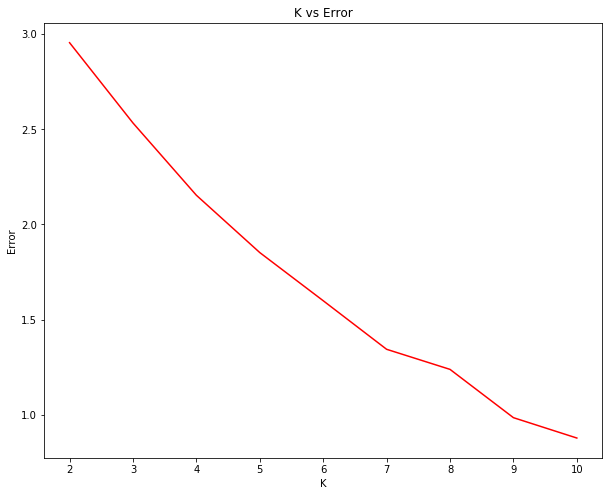

In [52]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 11), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 11))
plt.xlabel("K")
plt.ylabel("Error")

In [53]:
# set number of clusters #7 sems to be inflextion point
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,init='k-means++', random_state=0).fit(toronto_grp_clus)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [54]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto
# merge toronto_grouped with toronto to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

In [55]:
#Some neighbourhoods may have had no venues so drop these if they exist
toronto_merged.dropna(inplace=True)

In [56]:
#Convert cluster labels to integer
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head() # check the last columns!

,Borough,Postal Code,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,M4N,Lawrence Park,43.72843,-79.38713,4,Bus Line,Swim School,Yoga Studio,Elementary School,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm
1,Central Toronto,M4P,Davisville North,43.71276,-79.38851,0,Food & Drink Shop,Japanese Restaurant,Hotel,Department Store,Gym / Fitness Center,Breakfast Spot,Park,Dog Run,Event Space,Falafel Restaurant
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.71458,-79.40668,2,Playground,Gym Pool,Park,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
3,Central Toronto,M4S,Davisville,43.70340,-79.38659,0,Dessert Shop,Café,Pizza Place,Sandwich Place,Coffee Shop,Italian Restaurant,Gas Station,Thai Restaurant,Fast Food Restaurant,Park
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.69048,-79.38318,3,Playground,Gym,Trail,Dumpling Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


In [57]:
toronto_merged['Cluster Labels'].unique()

array([4, 0, 2, 3, 1, 6, 5])

In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters